In [10]:
import heapq
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d
from scipy.interpolate import splprep, splev

# 맵에서 상하좌우로 이동할 수 있는 방향을 나타내는 리스트

class PathPlanning():
    def __init__(self, map_path='./Images/asap_map_resized.pgm', middle_path='./Images/asap_map_middleLine.png'):
        self.MOVES = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.map = cv2.imread(map_path, cv2.COLOR_BGR2GRAY)
        self.middle = cv2.imread(middle_path, cv2.IMREAD_GRAYSCALE)
        crop_size = 16
        self.map = self.map[crop_size+2:-crop_size-2, crop_size:-crop_size]
        self.middle = self.middle[crop_size+2:-crop_size-2, crop_size:-crop_size]
        # wp number
        wp_num = {
            0 : (108, 237),
            1 : (88, 261),
            2 : (88, 275),
            3 : (58, 196),
            4 : (45, 196),
            5 : (44, 140),
            6 : (31, 140),
            7 : (37, 42),
            8 : (107, 28),
            9 : (178, 42),
            10 : (187, 140),
        #     wp_num[key] = (int([0] - crop_size), int(value[1]))
            11 : (170, 140),
            12 : (187, 196),
            13 : (171, 196),
            14 : (142, 276),
            15 : (142, 261),
            16 : (93, 173),
            17 : (93, 158),
            18 : (138, 173),
            19 : (138, 158),
            20 : (85,96),
            21 : (113, 49),
            22 : (150, 97),
            23 : (121, 237),
            24 : (44,95)
        }

        for key, value in wp_num.items():
            wp_num[key] = (int(value[0] - crop_size), int(value[1]) - crop_size-2)

        self.wp_num = wp_num

        # Waypoint 그래프
        self.waypoint_graph = {
            wp_num[0]: [wp_num[1], wp_num[14]],  # 0번 : 1, 14
            wp_num[1]: [wp_num[3]],  # 1번 : 3
            wp_num[2]: [wp_num[14], wp_num[23]],  # 2번 : 14, 23
            wp_num[3]: [wp_num[16], wp_num[20], wp_num[21]],  # 3번 : 16, 20
            wp_num[4]: [wp_num[2]],  # 4번 : 2
            wp_num[5]: [wp_num[16]],  # 5번 : 16
            wp_num[6]: [wp_num[4]],  # 6번 : 4
            wp_num[7]: [wp_num[6], wp_num[24]],  # 7번 : 6, 24
            wp_num[8]: [wp_num[7]],  # 8번 : 7
            wp_num[9]: [wp_num[8]],  # 9번 : 8
            wp_num[10]: [wp_num[9]],  # 10번 : 9
            wp_num[11]: [wp_num[13], wp_num[19]],  # 11번 : 13, 19
            wp_num[12]: [wp_num[10], wp_num[19]],  # 12번 : 10, 19
            wp_num[13]: [wp_num[15]],  # 13번 : 15
            wp_num[14]: [wp_num[12]],  # 14번 : 12
            wp_num[15]: [wp_num[1], wp_num[23]],  # 15번 : 1, 23
            wp_num[16]: [wp_num[18]],  # 16번 : 18
            wp_num[17]: [wp_num[4], wp_num[20], wp_num[21]],  # 17번 : 4, 20, 21
            wp_num[18]: [wp_num[10], wp_num[13]],  # 18번 : 10, 13
            wp_num[19]: [wp_num[17]],  # 19번 : 17
            wp_num[20]: [wp_num[21], wp_num[22]],  # 20번 : 21, 22
            wp_num[21]: [wp_num[11]],  # 21번 : 11
            wp_num[22]: [wp_num[11]],  # 22번 : 11

            wp_num[23]: [],  # 23번 : 도착 시 행하는 명령어만 따로 만들기

            wp_num[24]: [wp_num[5], wp_num[6]],  # 24번 : 5, 6  
        }

    # pgm 지도를 이진화 형태로 변환
    def pixel_based_map(self, img):
        img_height, img_width = img.shape 
        map_cost = np.ones((img_height, img_width), dtype=int)

        for i in range(img_height):
            for j in range(img_width):
                if img[i, j] > 210:  
                    map_cost[i, j] = 0 
                else:  
                    map_cost[i, j] = 1 

        return map_cost


    # 가장 적은 비용을 가진 두 wp 가져오기
    def find_two_smallest(self, cost_list):
        min1, min2 = float('inf'), float('inf')  

        for value in cost_list:
            if value < min1:
                min2 = min1  
                min1 = value  
            elif value < min2: 
                min2 = value 

        return min1, min2, cost_list.index(min1), cost_list.index(min2)


    # 장애물 근처에 가중치 맵 생성하기
    def create_weight_map(self, grid, middle, buffer_size, penalty):
        background = grid  # 이진화 된 배열 형태의 전체 map
        overlay = middle  # 이진화 된 배열 형태의 중앙선 map

        x, y = 18, 19  # 중앙선 map 을 삽입할 위치

        background_result = background.astype('uint8')
        overlay = overlay.astype('uint8')

        h, w = overlay.shape[:2]
        background_roi = background_result[y:y+h, x:x+w]

        result_roi = background_roi - overlay

        background_result[y:y+h, x:x+w] = result_roi

        plt.imshow(background_result, cmap='gray')
    
        obstacle = background_result == 1
        # 장애물 주변에 가중치를 부여
        dilated_obstacle = binary_dilation(obstacle, structure=np.ones((buffer_size, buffer_size)))
        weight_map = np.zeros_like(background_result, dtype=float)
        weight_map[dilated_obstacle] = penalty
        return weight_map, background_result

    # 휴리스틱 함수 : 유클리드 거리 계산
    def euclidean_distance(self, p1, p2):
        return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
        # return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

    def a_star(self, start, goal, waypoint_graph=None, grid=None, weight_map=None):
        # waypoint 기반 전역 경로 pathplanning
        if grid is None and weight_map is None:
            # print('waypoint 기반 전역 경로 pathplanning')
            """ A* 알고리즘을 사용하여 start에서 goal까지 최단 경로 찾기 """
            open_set = []  # 우선순위 큐 (힙)
            heapq.heappush(open_set, (0, start))  # (f_score, node)
            
            came_from = {}  # 경로 추적을 위한 딕셔너리
            g_score = {node: float('inf') for node in waypoint_graph}  # 시작점에서의 거리
            g_score[start] = 0
            f_score = {node: float('inf') for node in waypoint_graph}  # 휴리스틱 거리 포함 점수
            f_score[start] = self.euclidean_distance(start, goal)
            
            while open_set:
                _, current = heapq.heappop(open_set)  # f_score가 가장 낮은 노드 선택
                
                if current == goal:
                    # 최단 경로를 재구성하여 반환
                    path = []
                    while current in came_from:
                        path.append(current)
                        current = came_from[current]
                    path.append(start)
                    return path[::-1]  # 역순으로 반환
                
                for neighbor in waypoint_graph[current]:
                    tentative_g_score = g_score[current] + self.euclidean_distance(current, neighbor)
                    
                    if tentative_g_score < g_score[neighbor]:
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g_score
                        f_score[neighbor] = tentative_g_score + self.euclidean_distance(neighbor, goal)
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))
            
            return None  # 경로가 없는 경우
        # 두 waypoint 사이 pathplanning
        else:
            # print('waypoint 사이의 거리 pathplanning')
            open_set = []
            heapq.heappush(open_set, (0 + self.euclidean_distance(start, goal), 0, start))
            g_costs = {start: 0}

            came_from = {}

            while open_set:
                _, current_cost, current = heapq.heappop(open_set)

                if current == goal:
                    path = []
                    while current in came_from:
                        path.append(current)
                        current = came_from[current]
                    path.append(start)
                    path.reverse()

                    # goal까지의 총 비용 출력
                    # print(f"Total cost from {start} to {goal}: {g_costs[goal]}")
                    return path, g_costs[goal]
                
                for move in self.MOVES:
                    neighbor = (current[0] + move[0], current[1] + move[1])
                    if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1] and grid[neighbor] == 0:
                        tentative_g_cost = current_cost + 1 + weight_map[neighbor]  # 가중치 추가
                        if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                            g_costs[neighbor] = tentative_g_cost
                            f_cost = tentative_g_cost + self.euclidean_distance(neighbor, goal)
                            # f_cost = tentative_g_cost + manhattan_distance(neighbor, goal)
                            heapq.heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                            came_from[neighbor] = current
            return None


        # 주 지도
        
    def generate_waypoint(self, start_point, goal_point):
        # 지도 변환 pgm -> 이진 배열 (0: 도로, 1: 장애물)
        grid = self.pixel_based_map(self.map)
        plt.imshow(grid, cmap='gray')

        # Waypoints 시각화
        for wp, neighbors in self.waypoint_graph.items():
            plt.scatter(wp[0], wp[1], color='yellow', marker='x', s=50)  # Waypoint

        # 최초 호출, 반납 여부
        call_sig = 0
        return_sig = 0

        # min1, min2 선택 여부
        min1_take = None
        min2_take = None

        # 테스트 실행
        start = start_point  # 시작 좌표
        goal = self.wp_num[12]  # 목표 좌표
        if return_sig == 1:
            goal = self.wp_num[23]  # 목표 좌표

        # 장애물 주변 가중치 추가
        weight_map, background_result = self.create_weight_map(grid, self.middle, buffer_size=10, penalty=5)

        # 우선 waypoint 기반 전역 경로 생성
        if start not in self.waypoint_graph:  # 시작점이 waypoint 가 아니면
            cost_list = []
            for station in self.waypoint_graph:
                _, g_cost = self.a_star((start[1], start[0]), (station[1], station[0]), self.waypoint_graph, grid, weight_map)
                cost_list.append(g_cost)
            
            min1, min2, min1_idx, min2_idx = self.find_two_smallest(cost_list)

            # print(f"최소 비용 wp : {min1_idx}번, 비용 : {min1}")
            # print(f"두 번째로 작은 비용 wp : {min2_idx}번, 비용 : {min2}")

            if min1_idx == 20 and min2_idx == 21 and start[1] < 90:
                new_start, idx = self.wp_num[min2_idx], min2_idx
                min2_take = 1
                # print('min2 선택!')
            else:
                new_start, idx = self.wp_num[min1_idx], min1_idx
                min1_take = 1
                # print('min1 선택!')

            # closest_wp = find_closest_wp(start, waypoint_graph, grid, weight_map)
            # print(f"시작점이 waypoint_graph에 없으므로, {new_start} (wp[{idx}])로 이동한 후 전역 경로를 찾습니다.")
            # closest_wp에서 goal까지 전역 경로를 찾기 위해 A* 실행
            wp_path = self.a_star(new_start, goal, self.waypoint_graph)
        else:
            wp_path = self.a_star(start, goal, self.waypoint_graph)

        # wp_path = a_star(start, goal, waypoint_graph)

        # print("최단 경로:", wp_path)
        # print('-' * 50)

        # 시작점, 목표점
        plt.scatter(start[0], start[1], color='blue', marker='o', label='Start', s=50)
        plt.scatter(goal[0], goal[1], color='red', marker='x', label='Goal', s=50)

        # 전역 경로 사이 두 waypoint 간의 pathplanning 실행
        if wp_path:
            linked_path = []
            if min1_take == 1:
                for_cnt = len(wp_path) - 1
            elif min2_take == 1:
                for_cnt = len(wp_path)

            for i in range(for_cnt):
                if ((i == 0) and (wp_path[i] != start)):
                    if len(wp_path) == 1:
                        # print('wp_path 값이 하나일 때')
                        wp_start = start
                        wp_goal = wp_path[i]
                    else:
                        # print('맨 처음 조건문')
                        # print(f"min1_take = {min1_take}")
                        if min1_take is None and min2_take == 1:
                            wp_path.insert(0, new_start)  # 이게 min2_take 일 때
                        elif min2_take is None and min1_take == 1:
                            wp_path[0] = start
                        wp_start = start
                        wp_goal = wp_path[i + 1]
                    
                else:
                    # print('마지막 조건문')
                    wp_start = wp_path[i]
                    wp_goal = wp_path[i + 1]

                all_path, _ = (self.a_star((wp_start[1], wp_start[0]), (wp_goal[1], wp_goal[0]), self.waypoint_graph, grid=grid, weight_map=weight_map))
                real_path = np.array(all_path)
                        
                real_path = real_path[::20]  # 10개 간격으로 샘플링

                # 경로 마지막 좌표가 waypoint 좌표가 아니면 waypoint 좌표로 맞춰주기
                if (len(wp_path) != 1) and (tuple(real_path[-1]) != (wp_goal[1], wp_goal[0])):
                    real_path[-1] = (wp_goal[1], wp_goal[0])

                linked_path.append(real_path)
                # print(f"{i + 1} 번째 경로의 start : {(real_path[0])}, goal : {(real_path[-1])}, wp_goal : {wp_goal}")
                
                # print(real_path)
                
                path_x = real_path[:, 0]
                path_y = real_path[:, 1]

                # print(f"현재 구간 real_path 갯수 {len(real_path)}, x_path 갯수 {len(path_x)}")

                m = len(path_x)  # 데이터 개수
                k = (3, m - 1)  # 최소한 m > k 조건을 만족하도록 설정

                # b - spline 보간법
                try:
                    tck, u = splprep([path_x, path_y], s=3, k=k)  # s 가 클수록 부드러운 곡선
                    u_fine = np.linspace(0, 1, 200)  # 값이 클수록 세밀한 보간
                    smooth_x, smooth_y = splev(u_fine, tck)

                    plt.plot(smooth_y, smooth_x, 'green', linewidth=2, label='Path')
                except:
                    plt.plot(real_path[:, 1], real_path[:, 0], color='green', linewidth=2, label="Path")    

            return np.concatenate(linked_path), wp_path
        else:
            print('No path found')


In [11]:
a = eval('[[1, 2], [3, 4]]')

In [8]:
type(a)

list

In [12]:
import heapq
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
from scipy.interpolate import interp1d
from scipy.interpolate import splprep, splev

# 맵에서 상하좌우로 이동할 수 있는 방향을 나타내는 리스트

class PathPlanning():
    def __init__(self, map_path='./Images/asap_map_resized.pgm', middle_path='./Images/asap_map_middleLine.png'):
        self.MOVES = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        self.map = cv2.imread(map_path, cv2.COLOR_BGR2GRAY)
        self.middle = cv2.imread(middle_path, cv2.IMREAD_GRAYSCALE)
        self.grid = None 
        self.background = None
        crop_size = 16
        self.map = self.map[crop_size+2:-crop_size-2, crop_size:-crop_size]
        self.middle = self.middle[crop_size+2:-crop_size-2, crop_size:-crop_size]
        self.start, self.goal = None, None 

        # wp number
        wp_num = {
            0 : (108, 237),
            1 : (88, 261),
            2 : (88, 275),
            3 : (58, 196),
            4 : (45, 196),
            5 : (44, 140),
            6 : (31, 140),
            7 : (37, 42),
            8 : (107, 28),
            9 : (178, 42),
            10 : (187, 140),
        #     wp_num[key] = (int([0] - crop_size), int(value[1]))
            11 : (170, 140),
            12 : (187, 196),
            13 : (171, 196),
            14 : (142, 276),
            15 : (142, 261),
            16 : (93, 173),
            17 : (93, 158),
            18 : (138, 173),
            19 : (138, 158),
            20 : (85,96),
            21 : (113, 49),
            22 : (150, 97),
            23 : (121, 237),
            24 : (44,95)
        }

        for key, value in wp_num.items():
            wp_num[key] = (int(value[0] - crop_size), int(value[1]) - crop_size-2)

        self.wp_num = wp_num

        # Waypoint 그래프
        self.waypoint_graph = {
            wp_num[0]: [wp_num[1], wp_num[14]],  # 0번 : 1, 14
            wp_num[1]: [wp_num[3]],  # 1번 : 3
            wp_num[2]: [wp_num[14], wp_num[23]],  # 2번 : 14, 23
            wp_num[3]: [wp_num[16], wp_num[20], wp_num[21]],  # 3번 : 16, 20
            wp_num[4]: [wp_num[2]],  # 4번 : 2
            wp_num[5]: [wp_num[16]],  # 5번 : 16
            wp_num[6]: [wp_num[4]],  # 6번 : 4
            wp_num[7]: [wp_num[6], wp_num[24]],  # 7번 : 6, 24
            wp_num[8]: [wp_num[7]],  # 8번 : 7
            wp_num[9]: [wp_num[8]],  # 9번 : 8
            wp_num[10]: [wp_num[9]],  # 10번 : 9
            wp_num[11]: [wp_num[13], wp_num[19]],  # 11번 : 13, 19
            wp_num[12]: [wp_num[10], wp_num[19]],  # 12번 : 10, 19
            wp_num[13]: [wp_num[15]],  # 13번 : 15
            wp_num[14]: [wp_num[12]],  # 14번 : 12
            wp_num[15]: [wp_num[1], wp_num[23]],  # 15번 : 1, 23
            wp_num[16]: [wp_num[18]],  # 16번 : 18
            wp_num[17]: [wp_num[4], wp_num[20], wp_num[21]],  # 17번 : 4, 20, 21
            wp_num[18]: [wp_num[10], wp_num[13]],  # 18번 : 10, 13
            wp_num[19]: [wp_num[17]],  # 19번 : 17
            wp_num[20]: [wp_num[21], wp_num[22]],  # 20번 : 21, 22
            wp_num[21]: [wp_num[11]],  # 21번 : 11
            wp_num[22]: [wp_num[11]],  # 22번 : 11

            wp_num[23]: [],  # 23번 : 도착 시 행하는 명령어만 따로 만들기

            wp_num[24]: [wp_num[5], wp_num[6]],  # 24번 : 5, 6  
        }

    # pgm 지도를 이진화 형태로 변환
    def pixel_based_map(self, img):
        img_height, img_width = img.shape 
        map_cost = np.ones((img_height, img_width), dtype=int)

        for i in range(img_height):
            for j in range(img_width):
                if img[i, j] > 210:  
                    map_cost[i, j] = 0 
                else:  
                    map_cost[i, j] = 1 

        return map_cost


    # 가장 적은 비용을 가진 두 wp 가져오기
    def find_two_smallest(self, cost_list):
        min1, min2 = float('inf'), float('inf')  

        for value in cost_list:
            if value < min1:
                min2 = min1  
                min1 = value  
            elif value < min2: 
                min2 = value 

        return min1, min2, cost_list.index(min1), cost_list.index(min2)


    # 장애물 근처에 가중치 맵 생성하기
    def create_weight_map(self, grid, middle, buffer_size, penalty):
        background = grid  # 이진화 된 배열 형태의 전체 map
        overlay = middle  # 이진화 된 배열 형태의 중앙선 map

        x, y = 18, 19  # 중앙선 map 을 삽입할 위치

        background_result = background.astype('uint8')
        overlay = overlay.astype('uint8')

        h, w = overlay.shape[:2]
        background_roi = background_result[y:y+h, x:x+w]

        result_roi = background_roi - overlay

        background_result[y:y+h, x:x+w] = result_roi
        self.background = background_result 
        # plt.imshow(background_result, cmap='gray')
    
        obstacle = background_result == 1
        # 장애물 주변에 가중치를 부여
        dilated_obstacle = binary_dilation(obstacle, structure=np.ones((buffer_size, buffer_size)))
        weight_map = np.zeros_like(background_result, dtype=float)
        weight_map[dilated_obstacle] = penalty
        return weight_map, background_result

    # 휴리스틱 함수 : 유클리드 거리 계산
    def euclidean_distance(self, p1, p2):
        return ((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2) ** 0.5
        # return abs(p1[0] - p2[0]) + abs(p1[1] - p2[1])

    def a_star(self, start, goal, waypoint_graph=None, grid=None, weight_map=None):
        # waypoint 기반 전역 경로 pathplanning
        if grid is None and weight_map is None:
            # print('waypoint 기반 전역 경로 pathplanning')
            """ A* 알고리즘을 사용하여 start에서 goal까지 최단 경로 찾기 """
            open_set = []  # 우선순위 큐 (힙)
            heapq.heappush(open_set, (0, start))  # (f_score, node)
            
            came_from = {}  # 경로 추적을 위한 딕셔너리
            g_score = {node: float('inf') for node in waypoint_graph}  # 시작점에서의 거리
            g_score[start] = 0
            f_score = {node: float('inf') for node in waypoint_graph}  # 휴리스틱 거리 포함 점수
            f_score[start] = self.euclidean_distance(start, goal)
            
            while open_set:
                _, current = heapq.heappop(open_set)  # f_score가 가장 낮은 노드 선택
                
                if current == goal:
                    # 최단 경로를 재구성하여 반환
                    path = []
                    while current in came_from:
                        path.append(current)
                        current = came_from[current]
                    path.append(start)
                    return path[::-1]  # 역순으로 반환
                
                for neighbor in waypoint_graph[current]:
                    tentative_g_score = g_score[current] + self.euclidean_distance(current, neighbor)
                    
                    if tentative_g_score < g_score[neighbor]:
                        came_from[neighbor] = current
                        g_score[neighbor] = tentative_g_score
                        f_score[neighbor] = tentative_g_score + self.euclidean_distance(neighbor, goal)
                        heapq.heappush(open_set, (f_score[neighbor], neighbor))
            
            return None  # 경로가 없는 경우
        # 두 waypoint 사이 pathplanning
        else:
            # print('waypoint 사이의 거리 pathplanning')
            open_set = []
            heapq.heappush(open_set, (0 + self.euclidean_distance(start, goal), 0, start))
            g_costs = {start: 0}

            came_from = {}

            while open_set:
                _, current_cost, current = heapq.heappop(open_set)

                if current == goal:
                    path = []
                    while current in came_from:
                        path.append(current)
                        current = came_from[current]
                    path.append(start)
                    path.reverse()

                    # goal까지의 총 비용 출력
                    # print(f"Total cost from {start} to {goal}: {g_costs[goal]}")
                    return path, g_costs[goal]
                
                for move in self.MOVES:
                    neighbor = (current[0] + move[0], current[1] + move[1])
                    if 0 <= neighbor[0] < grid.shape[0] and 0 <= neighbor[1] < grid.shape[1] and grid[neighbor] == 0:
                        tentative_g_cost = current_cost + 1 + weight_map[neighbor]  # 가중치 추가
                        if neighbor not in g_costs or tentative_g_cost < g_costs[neighbor]:
                            g_costs[neighbor] = tentative_g_cost
                            f_cost = tentative_g_cost + self.euclidean_distance(neighbor, goal)
                            # f_cost = tentative_g_cost + manhattan_distance(neighbor, goal)
                            heapq.heappush(open_set, (f_cost, tentative_g_cost, neighbor))
                            came_from[neighbor] = current
            return None


        # 주 지도
        
    def generate_waypoint(self, start_point, goal_point):
        # 지도 변환 pgm -> 이진 배열 (0: 도로, 1: 장애물)
        grid = self.pixel_based_map(self.map)
        self.grid = grid 
        
        # 최초 호출, 반납 여부
        call_sig = 0
        return_sig = 0

        # min1, min2 선택 여부
        min1_take = None
        min2_take = None

        # 테스트 실행
        start = start_point  # 시작 좌표
        goal = self.wp_num[12]  # 목표 좌표
        self.start = start 
        self.goal = goal
        if return_sig == 1:
            goal = self.wp_num[23]  # 목표 좌표

        # 장애물 주변 가중치 추가
        print(self.middle.shape, self.map.shape)
        weight_map, background_result = self.create_weight_map(grid, self.middle, buffer_size=10, penalty=5)

        # 우선 waypoint 기반 전역 경로 생성
        if start not in self.waypoint_graph:  # 시작점이 waypoint 가 아니면
            cost_list = []
            for station in self.waypoint_graph:
                _, g_cost = self.a_star((start[1], start[0]), (station[1], station[0]), self.waypoint_graph, grid, weight_map)
                cost_list.append(g_cost)
            
            min1, min2, min1_idx, min2_idx = self.find_two_smallest(cost_list)

            # print(f"최소 비용 wp : {min1_idx}번, 비용 : {min1}")
            # print(f"두 번째로 작은 비용 wp : {min2_idx}번, 비용 : {min2}")

            if min1_idx == 20 and min2_idx == 21 and start[1] < 90:
                new_start, idx = self.wp_num[min2_idx], min2_idx
                min2_take = 1
                # print('min2 선택!')
            else:
                new_start, idx = self.wp_num[min1_idx], min1_idx
                min1_take = 1
                # print('min1 선택!')

            # closest_wp = find_closest_wp(start, waypoint_graph, grid, weight_map)
            # print(f"시작점이 waypoint_graph에 없으므로, {new_start} (wp[{idx}])로 이동한 후 전역 경로를 찾습니다.")
            # closest_wp에서 goal까지 전역 경로를 찾기 위해 A* 실행
            wp_path = self.a_star(new_start, goal, self.waypoint_graph)
        else:
            wp_path = self.a_star(start, goal, self.waypoint_graph)

        # wp_path = a_star(start, goal, waypoint_graph)

        # print("최단 경로:", wp_path)
        # print('-' * 50)

        

        # 전역 경로 사이 두 waypoint 간의 pathplanning 실행
        if wp_path:
            linked_path = []
            if min1_take == 1:
                for_cnt = len(wp_path) - 1
            elif min2_take == 1:
                for_cnt = len(wp_path)

            for i in range(for_cnt):
                if ((i == 0) and (wp_path[i] != start)):
                    if len(wp_path) == 1:
                        # print('wp_path 값이 하나일 때')
                        wp_start = start
                        wp_goal = wp_path[i]
                    else:
                        # print('맨 처음 조건문')
                        # print(f"min1_take = {min1_take}")
                        if min1_take is None and min2_take == 1:
                            wp_path.insert(0, new_start)  # 이게 min2_take 일 때
                        elif min2_take is None and min1_take == 1:
                            wp_path[0] = start
                        wp_start = start
                        wp_goal = wp_path[i + 1]
                    
                else:
                    # print('마지막 조건문')
                    wp_start = wp_path[i]
                    wp_goal = wp_path[i + 1]

                all_path, _ = (self.a_star((wp_start[1], wp_start[0]), (wp_goal[1], wp_goal[0]), self.waypoint_graph, grid=grid, weight_map=weight_map))
                real_path = np.array(all_path)
                        
                real_path = real_path[::20]  # 10개 간격으로 샘플링

                # 경로 마지막 좌표가 waypoint 좌표가 아니면 waypoint 좌표로 맞춰주기
                if (len(wp_path) != 1) and (tuple(real_path[-1]) != (wp_goal[1], wp_goal[0])):
                    real_path[-1] = (wp_goal[1], wp_goal[0])

                linked_path.append(real_path)
                # print(f"{i + 1} 번째 경로의 start : {(real_path[0])}, goal : {(real_path[-1])}, wp_goal : {wp_goal}")
            return np.concatenate(linked_path), wp_path
        else:
            print('No path found')

                
    def draw_path(self, real_path):
        # 시작점, 목표점
        plt.imshow(self.grid, cmap='gray')
        plt.imshow(self.background, cmap='gray')

        # Waypoints 시각화
        # for wp, neighbors in self.waypoint_graph.items():
        #     plt.scatter(wp[0], wp[1], color='yellow', marker='x', s=50)  # Waypoint

        plt.scatter(self.start[0], self.start[1], color='blue', marker='o', label='Start', s=50)
        plt.scatter(self.goal[0], self.goal[1], color='red', marker='x', label='Goal', s=50)

        # for real_path in linked_path:        
            # print(real_path)
            
        path_x = real_path[:, 0]
        path_y = real_path[:, 1]

        # print(f"현재 구간 real_path 갯수 {len(real_path)}, x_path 갯수 {len(path_x)}")

        m = len(path_x)  # 데이터 개수
        k = (3, m - 1)  # 최소한 m > k 조건을 만족하도록 설정

        # b - spline 보간법
        try:
            tck, u = splprep([path_x, path_y], s=3, k=k)  # s 가 클수록 부드러운 곡선
            u_fine = np.linspace(0, 1, 200)  # 값이 클수록 세밀한 보간
            smooth_x, smooth_y = splev(u_fine, tck)

            plt.plot(smooth_y, smooth_x, 'green', linewidth=2, label='Path')
        except:
            plt.plot(real_path[:, 1], real_path[:, 0], color='green', linewidth=2, label="Path")    

        


In [13]:
pathplanner = PathPlanning()

(232, 148) (270, 183)


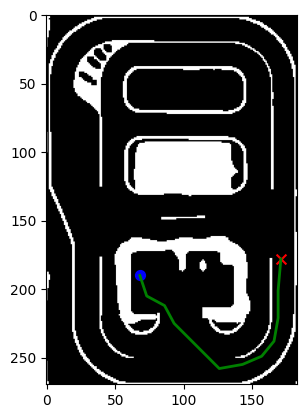

In [14]:
path, waypoints = pathplanner.generate_waypoint(start_point=(68, 190), goal_point=(183, 257))
pathplanner.draw_path(path)

In [38]:
np.linalg.norm(np.array([86, 153]) - np.array([183, 257]))

142.21462653327893

In [41]:
abs(86-183) + abs(153-257)

201

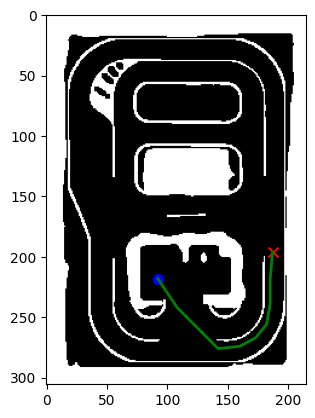

In [142]:
path[:, 1]

array([ 58,  67,  78, 113, 113, 132, 152, 165, 166, 166, 166, 170, 170,
       161, 138, 138, 118,  93,  93,  78,  68,  58,  45,  45,  45,  47,
        49,  56,  68,  88,  88, 108, 142, 142, 160, 173, 182, 185, 185,
       187])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

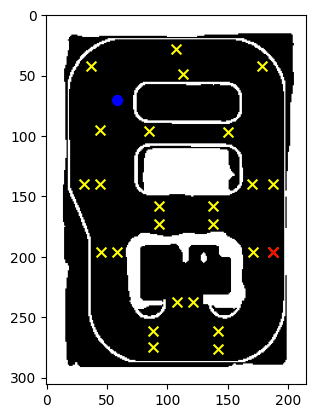

In [139]:
pathplanner.draw_path(path)

In [87]:
pathplanner.waypoint_graph

{(108, 237): [(88, 261), (142, 276)],
 (88, 261): [(58, 196)],
 (88, 275): [(142, 276), (121, 237)],
 (58, 196): [(93, 173), (85, 96), (113, 49)],
 (45, 196): [(88, 275)],
 (44, 140): [(93, 173)],
 (31, 140): [(45, 196)],
 (37, 42): [(31, 140), (44, 95)],
 (107, 28): [(37, 42)],
 (178, 42): [(107, 28)],
 (187, 140): [(178, 42)],
 (170, 140): [(171, 196), (138, 158)],
 (187, 196): [(187, 140), (138, 158)],
 (171, 196): [(142, 261)],
 (142, 276): [(187, 196)],
 (142, 261): [(88, 261), (121, 237)],
 (93, 173): [(138, 173)],
 (93, 158): [(45, 196), (85, 96), (113, 49)],
 (138, 173): [(187, 140), (171, 196)],
 (138, 158): [(93, 158)],
 (85, 96): [(113, 49), (150, 97)],
 (113, 49): [(170, 140)],
 (150, 97): [(170, 140)],
 (121, 237): [],
 (44, 95): [(44, 140), (31, 140)]}

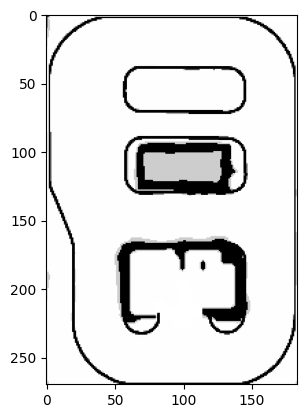

In [6]:
crop_size = 16
new_map = pathplanner.map[crop_size+2:-crop_size-2, crop_size:-crop_size]
nw, nh = new_map.shape
plt.imshow(new_map, cmap='gray')

In [45]:
nw,nh

(270, 183)